# Wiki For HE

*Gabriel Cardoso Salgado, Nov-2018*

This document contains study of data analysis based on [open dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/00334/) for data science exercises. Accoding to data source, this dataset contains a [research about use of Wikipedia on university with teachers opinions](http://archive.ics.uci.edu/ml/datasets/wiki4HE). Dataset is on file wiki4HE.csv, contains several informations about participant teachers, like:

* Age
* Gender
* Expertise (Arts & Humanities, Sciences, Health Sciences, Engineering & Architecture and Law & Politics)
* PhD (yes or no)
* Years on university
* University (UOC or UPF)
* And more details

Others columns on dataset are related to theirs opinion about use of Wikipedia by studies and researchs on university answearing some questions on scale from 1 to 5.

Importing used libraries on this study.

In [1]:
import warnings as wn
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import calinski_harabaz_score, make_scorer
from hdbscan import HDBSCAN as Model
sns.set_style('dark')

## Load

First step is load dataset.

In [2]:
df = pd.read_csv('rsc/wiki4HE.csv', sep = ';')

## Preprocess

There is missing data represented by *"?"*. Because of this, preprocess function is defined to resolve it.

In [3]:
def preprocess_nan(s, cut = True):
    s = s.replace('?', -1).astype(int)
    return s[s >= 0] if cut else s

## Basic visualization

And now let see how is data values distributed.

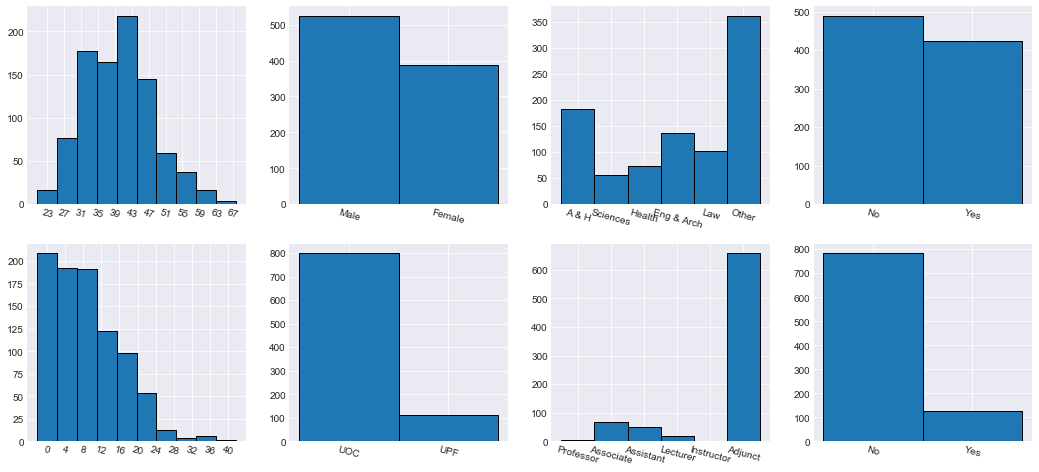

In [4]:
_, ax = plt.subplots(2, 4, figsize = (18, 8))
properties = [
    {'key': 'AGE',          'bins': 10, 'xlabels': None},
    {'key': 'GENDER',       'bins': 2,  'xlabels': ['Male', 'Female']},
    {'key': 'DOMAIN',       'bins': 6,  'xlabels': ['A & H', 'Sciences', 'Health', 'Eng & Arch', 'Law', 'Other']},
    {'key': 'PhD',          'bins': 2,  'xlabels': ['No', 'Yes']},
    {'key': 'YEARSEXP',     'bins': 10, 'xlabels': None},
    {'key': 'UNIVERSITY',   'bins': 2,  'xlabels': ['UOC', 'UPF']},
    {'key': 'UOC_POSITION', 'bins': 6,  'xlabels': ['Professor', 'Associate', 'Assistant', 'Lecturer', 'Instructor', 'Adjunct']},
    {'key': 'USERWIKI',     'bins': 2,  'xlabels': ['No', 'Yes']}
]
for prop, (row, col) in zip(properties, it.product(range(2), range(4))):
    s = preprocess_nan(df[prop['key']])
    r = range(s.min(), s.max() + 1, (s.max() + 1 - s.min()) // prop['bins'])
    a = s.hist(ax = ax[row, col], xrot = -15, bins = prop['bins'], range = (s.min(), (s.max() + 1)), align = 'left', edgecolor = 'black')
    a.set_xticks(r)
    if prop['xlabels']: a.set_xticklabels(prop['xlabels'])

We can note that:

* Age distribute around about 40 years.
* Gender has a little more male that female.
* Domain have 6 classes (despite that on source data page says about only 5 classes).
* PhD is nearly of equally distributed between yes and no.
* Number of teachers declines with years of experience.
* Has much more UOC that UPF on this research.
* There is much more UOC adjunt that others positions.
* Broad majority of teachers says that are not Wikipedia registered user.

## Basic statisticals

Lets see statisticals about these data:

In [5]:
# AGE
s = df['AGE']
N = len(s)
mean = round(s.mean())
std = round(s.std())
R = r1, r2, r3 = tuple([(mean - k*std), (mean + k*std)] for k in range(1, 4))
print('Mean age is %d.' % mean)
for r, k in zip(R, [68, 95, 99.7]):
    print('About of %.2f%% of teachers are between %d and %d years old.' % (k, r[0], r[1]))
    print('Exactly  %.2f%% of teachers are between %d and %d years old.' % (100 * len(s[(r[0] < s) & (s < r[1])]) / N, r[0], r[1]))
print()

# GENDER
s = df['GENDER']
print('There is %d Male and %d Female.\n' % tuple(len(s[s == k]) for k in (0, 1)))

# DOMAIN
s = preprocess_nan(df['DOMAIN'])
print('Domain distribution is %s.\n' % [len(s[s == k]) for k in range(1, 7)])

# PhD
s = df['PhD']
print('There is %d without PhD and %d with PhD.\n' % tuple(len(s[s == k]) for k in (0, 1)))

# YEARSEXP
s = preprocess_nan(df['YEARSEXP'])
print('Mean years of experience is %d.\n' % round(s.mean()))

# UNIVERSITY
s = df['UNIVERSITY']
print('There is %d from UOC and %d from UPF.\n' % tuple(len(s[s == k]) for k in (1, 2)))

# UOC_POSITION
s = preprocess_nan(df['UOC_POSITION'])
print('UOC position distribution is %s.\n' % [len(s[s == k]) for k in range(1, 7)])

# USERWIKI
s = preprocess_nan(df['USERWIKI'])
print('There is %d teachers that is not wiki user and %d registered wiki users.' % tuple(len(s[s == k]) for k in (0, 1)))

Mean age is 42.
About of 68.00% of teachers are between 34 and 50 years old.
Exactly  64.18% of teachers are between 34 and 50 years old.
About of 95.00% of teachers are between 26 and 58 years old.
Exactly  94.30% of teachers are between 26 and 58 years old.
About of 99.70% of teachers are between 18 and 66 years old.
Exactly  99.67% of teachers are between 18 and 66 years old.

There is 525 Male and 388 Female.

Domain distribution is [183, 56, 73, 137, 101, 361].

There is 489 without PhD and 424 with PhD.

Mean years of experience is 11.

There is 800 from UOC and 113 from UPF.

UOC position distribution is [3, 68, 50, 18, 2, 659].

There is 784 teachers that is not wiki user and 125 registered wiki users.


## Finding clusters

On variables hyper-space, it is possible that clusters with teachers can be find based on common features. First step is visualize matrix scatters with pairs of variables.

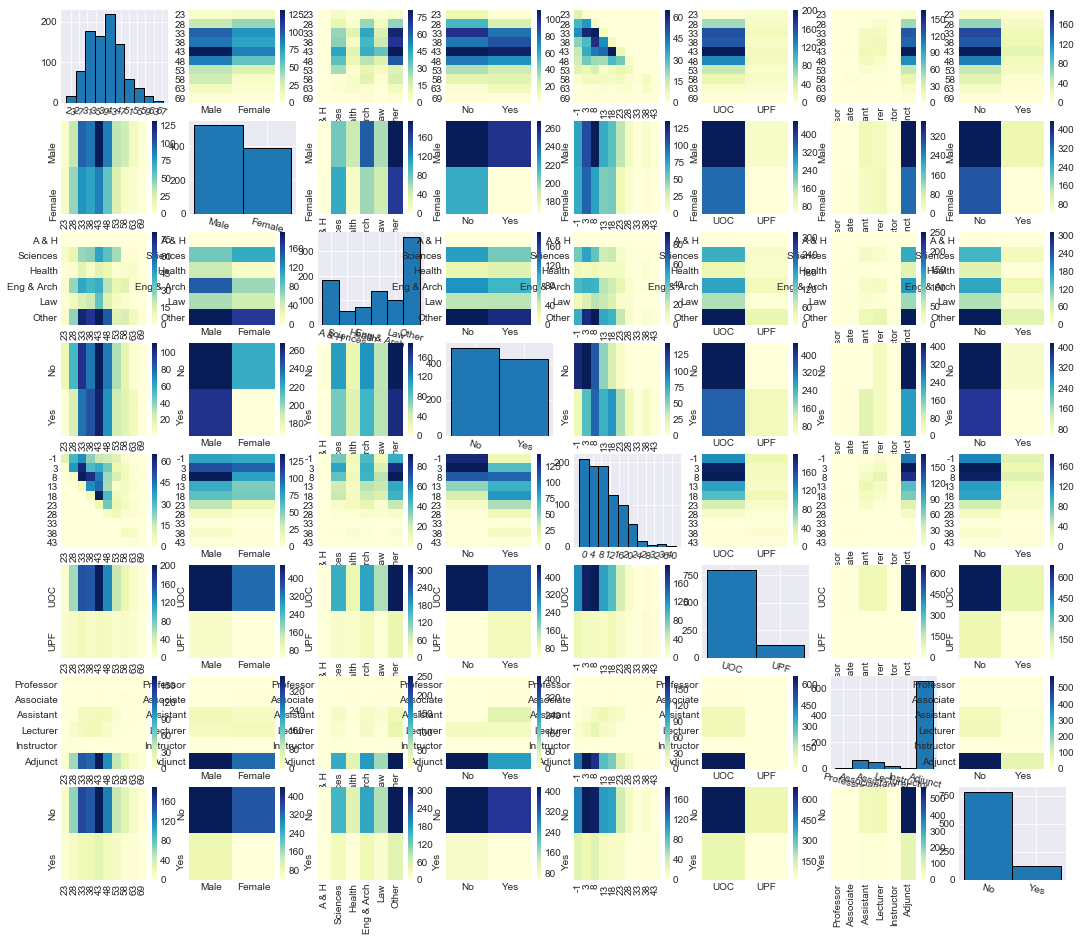

In [6]:
#pd.plotting.scatter_matrix(df[[prop['key'] for prop in properties]], figsize = (16, 16), alpha = 0.2)
#plt.show()

_, ax = plt.subplots(len(properties), len(properties), figsize = (18, 16))
for row, col in it.product(range(len(properties)), repeat = 2):
    if row == col:
        prop = properties[row]
        s = preprocess_nan(df[prop['key']])
        r = range(s.min(), s.max() + 1, (s.max() + 1 - s.min()) // prop['bins'])
        a = s.hist(ax = ax[row, col], xrot = -15, bins = prop['bins'], range = (s.min(), (s.max() + 1)), align = 'left', edgecolor = 'black')
        a.set_xticks(r)
        if prop['xlabels']: a.set_xticklabels(prop['xlabels'])
    else:
        prop1, prop2 = map(properties.__getitem__, (row, col))
        s1 = preprocess_nan(df[prop1['key']], cut = False)
        s2 = preprocess_nan(df[prop2['key']], cut = False)
        i = (s1 >= 0) & (s2 >= 0)
        h, _, __ = np.histogram2d(
            s1[i], s2[i],
            bins = [prop1['bins'], prop2['bins']],
            range = [[s1.min(), (s1.max() + 1)], [s2.min(), (s2.max() + 1)]])
        kw = {'ax': ax[row, col], 'cmap': 'YlGnBu'}
        if prop2['xlabels']: kw['xticklabels'] = prop2['xlabels']
        if prop1['xlabels']: kw['yticklabels'] = prop1['xlabels']
        sns.heatmap(h.astype(int),
            ax = ax[row, col],
            xticklabels = prop2['xlabels'] or np.linspace(s2.min(), s2.max(), h.shape[1], dtype = int),
            yticklabels = prop1['xlabels'] or np.linspace(s1.min(), s1.max(), h.shape[0], dtype = int),
            cmap = 'YlGnBu')
        #ax[row, col].scatter(s2[i], s1[i], alpha = 0.8)

This results is very interesting and much statisticals crossed analysis can be extracted. And now clustering this data allows to arrive on a final result about these data. Let transform not categorical data in categories with bands belonging. And categorical data with more than two classes will be binarized.

In [7]:
df_cls = pd.DataFrame()

# AGE
s = df['AGE']
borders = np.linspace(s.min(), s.max(), 5)
for group, (b0, b1) in enumerate(zip(borders[:-1], borders[1:]), 1):
    df_cls['AGE_%d' % group] = np.array(((b0 <= s) & (s < b1))).astype(int)

# GENDER
df_cls['GENDER'] = df['GENDER']

# DOMAIN
s = preprocess_nan(df['DOMAIN'], cut = False)
for value in range(1, 7):
    df_cls['DOMAIN_%d' % value] = np.array(s == value).astype(int)

# PhD
df_cls['PhD'] = df['PhD']

# YEARSEXP
s = preprocess_nan(df['YEARSEXP'], cut = False)
borders = np.linspace(s.min(), s.max(), 5)
for group, (b0, b1) in enumerate(zip(borders[:-1], borders[1:]), 1):
    df_cls['YEARSEXP_%d' % group] = np.array(((b0 <= s) & (s < b1))).astype(int)

# UNIVERSITY
df_cls['UNIVERSITY'] = df['UNIVERSITY'] - 1

# UOC_POSITION
s = preprocess_nan(df['UOC_POSITION'], cut = False)
for value in range(1, 7):
    df_cls['UOC_POSITION_%d' % value] = np.array(s == value).astype(int)

# USERWIKI
s = preprocess_nan(df['USERWIKI'], cut = False)
for value in range(2):
    df_cls['USERWIKI_%d' % value] = np.array(s == value).astype(int)

This new dataframe is ready to be applied on clusterizer like [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html).

There are 275 teachers that do not belong to any idetified clusters.
There are 64 identified clusters.


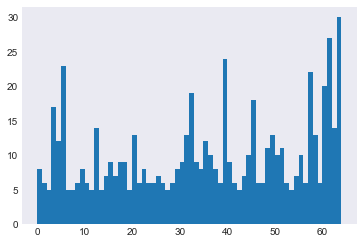

In [8]:
model = Model(min_cluster_size = 5)
y = model.fit_predict(df_cls.values)
if np.min(y) == -1: print('There are %d teachers that do not belong to any idetified clusters.' % sum(y == -1))
print('There are %d identified clusters.' % np.max(y))

plt.hist(y[y >= 0], bins = np.max(y))
plt.show()

Results are differents depending of min_cluster_size parameter. It can be optimized by [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

There are 689 teachers that do not belong to any idetified clusters.
There are 5 identified clusters.
Teachers distribution on cluster is [22, 24, 20, 30, 68]


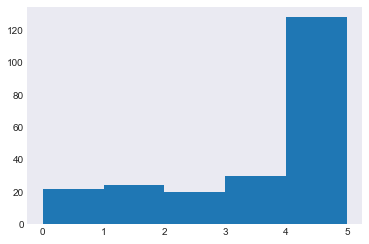

In [9]:
grid = {'min_cluster_size': [5, 10, 20, 30]}
scoring = lambda estimator, X: calinski_harabaz_score(X, estimator.fit_predict(X))
best = GridSearchCV(Model(), grid, scoring, error_score = 0).fit(df_cls.values)
y = best.best_estimator_.fit_predict(df_cls.values)

if np.min(y) == -1: print('There are %d teachers that do not belong to any idetified clusters.' % sum(y == -1))
print('There are %d identified clusters.' % np.max(y))
print('Teachers distribution on cluster is %s' % [sum(y == cls) for cls in range(np.max(y))])

plt.hist(y[y >= 0], bins = np.max(y))
plt.show()

On best score based on [Calinski-Harabaz](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html#sklearn.metrics.calinski_harabaz_score), there are 5 identified clusters. There is 689 teachers that do not belong to any of these clusters and only 164 teachers distributed on these 5 clusters.

## Relations with ENJ1 and ENJ2

Here is checked about possible relations between analysed variabels and opnions about Wikipedia on columns ENJ1 and ENJ2.

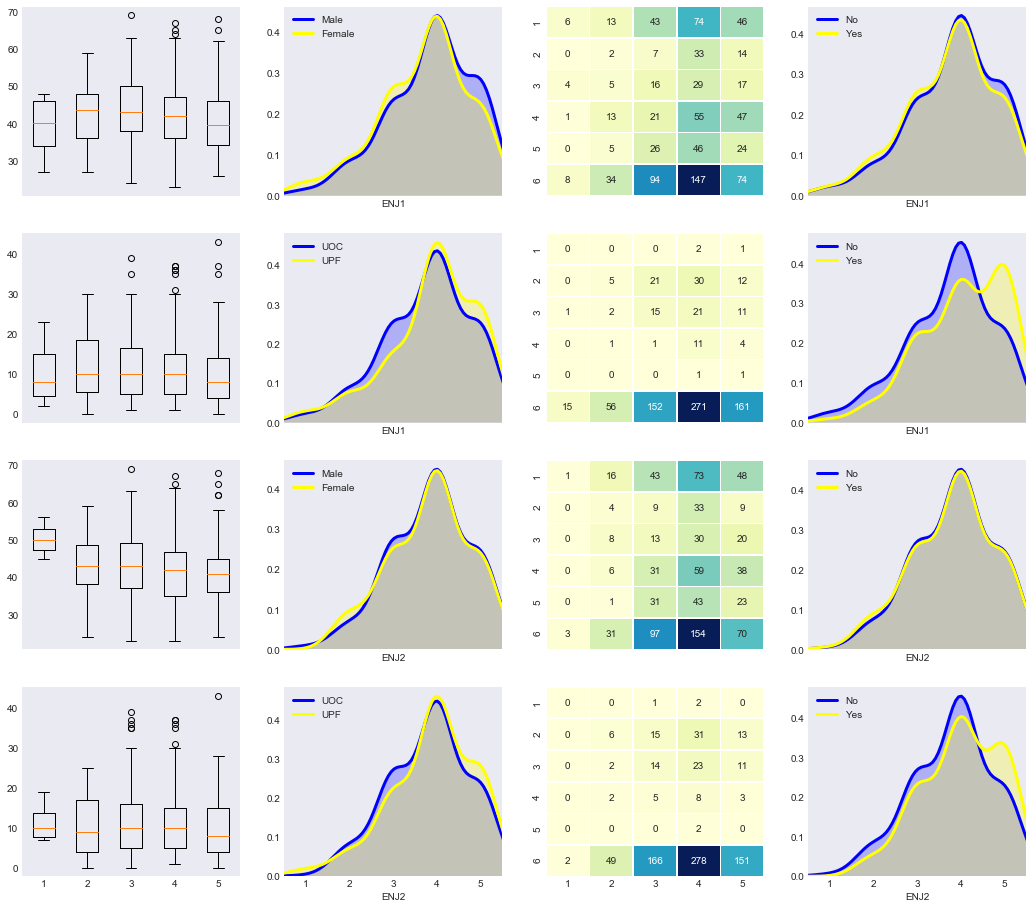

In [10]:
kernel_kw = {'hist': False, 'kde': True, 'kde_kws': {'shade': True, 'linewidth': 3, 'bw': 0.4}}
heatmap_kw = {'annot': True, 'fmt': 'd', 'linewidths': 0.5, 'cmap': 'YlGnBu', 'cbar': False, 'xticklabels': range(1, 6)}

_, ax = plt.subplots(4, 4, figsize = (18, 16), sharex = 'col')
for row0, output in zip(range(0, 4, 2), ('ENJ1', 'ENJ2')):
    y = preprocess_nan(df[output], False)
    
    # AGE
    ax[row0, 0].boxplot([df['AGE'].values[y == cls] for cls in range(1, 6)])
    
    # GENDER
    for value, color, label in zip((0, 1), ('blue', 'yellow'), ('Male', 'Female')):
        sns.distplot(y[df['GENDER'] == value], color = color, ax = ax[row0, 1], label = label, **kernel_kw)
    ax[row0, 1].legend()
    ax[row0, 1].set_xlim(0.5, 5.5)
    
    # DOMAIN
    s = preprocess_nan(df['DOMAIN'], False)
    y_copy = y[s >= 0]
    s = s[s >= 0]
    h, _, __ = np.histogram2d(s, y_copy, bins = [6, 5], range = [[s.min(), (s.max() + 1)], [1, 6]])
    sns.heatmap(h.astype(int), ax = ax[row0, 2], yticklabels = range(s.min(), (s.max() + 1)), **heatmap_kw)
    
    # PhD
    for value, color, label in zip((0, 1), ('blue', 'yellow'), ('No', 'Yes')):
        sns.distplot(y[df['PhD'] == value], color = color, ax = ax[row0, 3], label = label, **kernel_kw)
    ax[row0, 3].legend()
    ax[row0, 3].set_xlim(0.5, 5.5)
    
    # YEARSEXP
    s = preprocess_nan(df['YEARSEXP'], False)
    y_copy = y[s >= 0]
    s = s[s >= 0]
    ax[(row0 + 1), 0].boxplot([s.values[y_copy == cls] for cls in range(1, 6)])
    
    # UNIVERSITY
    for value, color, label in zip((1, 2), ('blue', 'yellow'), ('UOC', 'UPF')):
        sns.distplot(y[df['UNIVERSITY'] == value], color = color, ax = ax[(row0 + 1), 1], label = label, **kernel_kw)
    ax[(row0 + 1), 1].legend()
    
    # UOC_POSITION
    s = preprocess_nan(df['UOC_POSITION'], False)
    y_copy = y[s >= 0]
    s = s[s >= 0]
    h, _, __ = np.histogram2d(s, y_copy, bins = [6, 5], range = [[s.min(), (s.max() + 1)], [1, 6]])
    sns.heatmap(h.astype(int), ax = ax[(row0 + 1), 2], yticklabels = range(s.min(), (s.max() + 1)), **heatmap_kw)
    
    # USERWIKI
    s = preprocess_nan(df['USERWIKI'], False)
    y_copy = y[s >= 0]
    s = s[s >= 0]
    for value, color, label in zip((0, 1), ('blue', 'yellow'), ('No', 'Yes')):
        sns.distplot(y_copy[s == value], color = color, ax = ax[(row0 + 1), 3], label = label, **kernel_kw)
    ax[(row0 + 1), 3].legend()

First, visualizing boxplots, it not clear a correlation between age or years of experiance and opinion about Wikipedia curiosity stimulation (measured as ENJ1). But about entertaining (measured as ENJ2), we can see that generaly teachers that not agree that Wikipedia is entertaining are olders, but ohters available levels opinions distributes on broad age range, form youngers to olders.

On kernel density estimation and heatmaps, opinions ENJ1 and ENJ2 distributes on same forms independently of gender, have or not PhD, university be UOC or UPF or position on UOC. These graphics also reveals that majority of teachers choose levels about 3, 4 and 5. Level 4 is most choosen on this research at both ENJ1 and ENJ2.

In [11]:
# ENJ1
s = preprocess_nan(df['ENJ1'])
print('ENJ1 distribution is %s.\n' % [len(s[s == k]) for k in range(1, 6)])

# ENJ2
s = preprocess_nan(df['ENJ2'])
print('ENJ2 distribution is %s.\n' % [len(s[s == k]) for k in range(1, 6)])

ENJ1 distribution is [19, 72, 207, 386, 222].

ENJ2 distribution is [4, 66, 224, 394, 208].



## Conclusion

This study explored dataset on file wiki4EH.csv and presented statisticals analysis on each variable and possible relations with opinion about Wikipedia curiosity stimulation and entertaining.

Basic visualization and statisticals was shown. Then advanced analysis on data was done with clusterization. There are 5 identified clusters of teachers based on common features.

On final step, some possible relations with opinion about Wikipedia, variables ENJ1 and ENJ2, were explored. Only one significant relation was noted, about age of teachers that do not agree that Wikipedia is well entertaining.